In [2]:
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from scipy.stats import mannwhitneyu, ttest_ind
from tqdm import tqdm
import numpy as np
import math
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


In [3]:

def load_ipeds_unis(fname='../../data/IPEDS/hd2020.csv', encoding='cp1252'):
    return pd.read_csv(fname, encoding=encoding)

def filter_only_rs_and_las(unis):
    unis = unis[unis['C18BASIC'].apply(lambda x: x in [15, 16, 17, 21, 22])]
    unis['Y']  = unis['C18BASIC'].apply(lambda x: 'liberal_arts' if x in [21, 22] else 'research')
    return unis

unis     = load_ipeds_unis()

In [4]:
fnames         = glob('../../data/IPEDS/*_A/*_rv.csv')+glob('../../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]

In [5]:
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]

years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])


In [6]:

def get_absolutes(var, var_alt):
    abs_df = [df.groupby('CS').apply( \
                lambda x: x[var].sum() if var in df.columns else x[var_alt].sum()) \
                for year, df in cs_and_noncs]
    abs_df = pd.concat(abs_df, axis=1).transpose()
    return abs_df

women_abs    = get_absolutes('CTOTALW', 'CRACE16')
black_abs    = get_absolutes('CBKAAT',  'CRACE18')
hispanic_abs = get_absolutes('CHISPT',  'CRACE21')
natives_abs  = get_absolutes('CAIANT',  'CRACE19')



In [10]:
women_abs

CS,False,True,years
0,1568949,13571,2002
1,1636637,16063,2003
2,1701655,15459,2004
3,1756889,12551,2005
4,1817274,10156,2006
5,1863037,8093,2007
6,1903703,7069,2008
7,1946173,7081,2009
8,2004507,7493,2010
9,2088419,7927,2011


In [9]:
women_abs['years']  = [year for year, _ in cs_and_noncs]
black_abs['years']  = [year for year, _ in cs_and_noncs]
hispanic_abs['years']  = [year for year, _ in cs_and_noncs]

women_abs.to_csv('../../data/women_abs.csv')
black_abs.to_csv('../../data/black_abs.csv')
hispanic_abs.to_csv('../../data/hispanic_abs.csv')

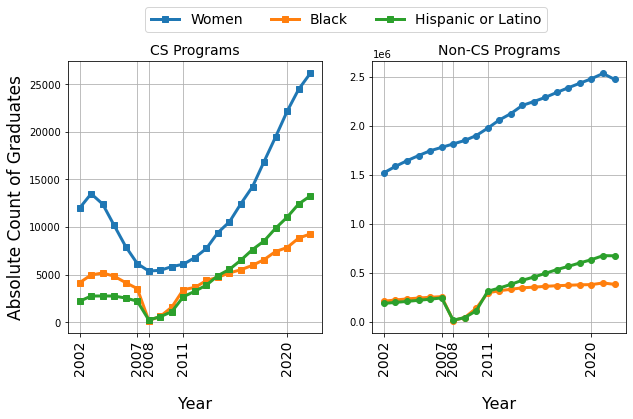

In [116]:
fig, axs       = plt.subplots(1, 2, figsize=(10,5))

_ = [axs[0].plot(df, linewidth=3, marker='s') for df in [women_abs[True], black_abs[True], hispanic_abs[True]]]
# axs[0].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[0].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[0].set_title('CS Programs', color='black', fontsize=14);
# axs[0].legend(['Women', 'Black', 'Hispanic', 'Native American']);

_ = [axs[1].plot(df, linewidth=3, marker='o') for df in [women_abs[False], black_abs[False], hispanic_abs[False]]]
# axs[1].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[1].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[1].set_title('Non-CS Programs', color='black', fontsize=14);
# axs[1].legend(['Women', 'Black', 'Hispanic', 'Native American']);

# handles, labels = axs[0].get_legend_handles_labels()
fig.legend(['Women', 'Black', 'Hispanic or Latino'], ncol=4, fontsize=14, bbox_to_anchor=(0.8, 1.05))

axs[0].set_ylabel('Absolute Count of Graduates', color='black', fontsize=17);
axs[0].set_xlabel('\nYear', color='black', fontsize=16);
axs[1].set_xlabel('\nYear', color='black', fontsize=16);

axs[0].grid();
axs[1].grid();

# plt.xlim(2018, 2022)

## Percentages

In [70]:
fnames         = glob('../../data/IPEDS/*_A/*_rv.csv')+glob('../../data/IPEDS/*_a.csv')
fnames         = [fname for fname in fnames if ('2000' not in fname) and ('2001' not in fname)]
dfs            = [pd.read_csv(fname, index_col=0) for fname in fnames]
dfs            = [df.rename(columns={col: col.upper().strip() for col in df.columns}) for df in dfs]
dfs            = [df[df['AWLEVEL']==5] for df in dfs]
cs_maps        = [df['CIPCODE'].apply(lambda x: (x>=11) & (x<12)) for df in dfs]
cs_maps        = [cs_map.rename('CS') for cs_map in cs_maps] 
cs_and_noncs   = [df.groupby([cs_maps[i], df.index]).sum().reset_index() for i, df in enumerate(dfs)]


years          = [int(fname.split('/')[-1].split('_')[0][1:]) for fname in fnames]
cs_and_noncs   = sorted(zip(years, cs_and_noncs), key=lambda x: x[0])

In [110]:
def get_odd_ratio(all_years, var, var_alt):
    odds_df = [(df[df['CS']][var].sum()*100     / df[var].sum() if var in df.columns else\
               df[df['CS']][var_alt].sum()*100 / df[var_alt].sum())\
        for year, df in all_years]
    
    # odds_df = pd.concat(odds_df, axis=1).transpose()
    return odds_df

women_odds    = get_odd_ratio(cs_and_noncs, 'CTOTALW', 'CRACE16')
black_odds    = get_odd_ratio(cs_and_noncs, 'CBKAAT',  'CRACE18')
hispanic_odds = get_odd_ratio(cs_and_noncs, 'CHISPT',  'CRACE21')
natives_odds  = get_odd_ratio(cs_and_noncs, 'CAIANT',  'CRACE19')


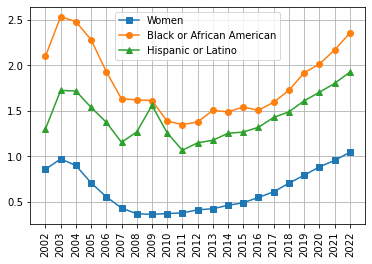

In [126]:
plt.plot(women_odds, marker='s', label='Women');
plt.plot(black_odds, marker='o', label='Black or African American');
plt.plot(hispanic_odds, marker='^', label='Hispanic or Latino');
plt.legend()
# plt.yscale('log')
plt.grid()
plt.xticks(range(len(hispanic_odds)), [x for x, _ in cs_and_noncs], rotation=90);

In [76]:
def get_percentages(var, var_alt):
    abs_df = [df.groupby('CS').apply( lambda x:\
            x[var].sum()     / x['CTOTALT'].sum()        if var in df.columns      else\
            x[var_alt].sum() / x['CRACE24'].sum()        if 'CRACE24' in df.columns else\
            x[var_alt].sum() / (x['CRACE15']+x['CRACE16']).sum())\
        for year, df in cs_and_noncs]
    
    abs_df = pd.concat(abs_df, axis=1).transpose()
    return abs_df

women_pct    = get_percentages(cs_and_noncs, 'CTOTALW', 'CRACE16')
black_pct    = get_percentages('CBKAAT',  'CRACE18')
hispanic_pct = get_percentages('CHISPT',  'CRACE21')
natives_pct  = get_percentages('CAIANT',  'CRACE19')

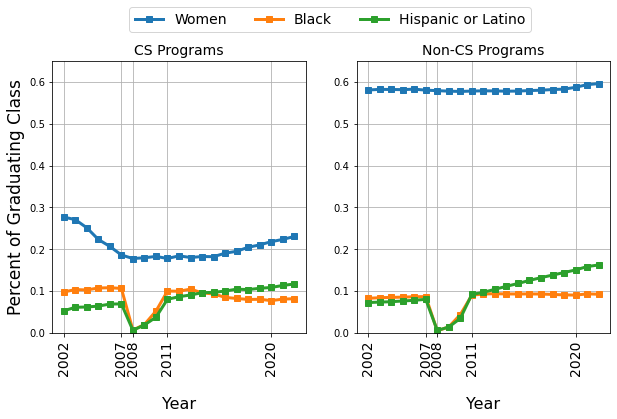

In [77]:
fig, axs       = plt.subplots(1, 2, figsize=(10,5))

axs[0].plot(women_pct[True], linewidth=3, marker='s')
axs[0].plot(black_pct[True], linewidth=3, marker='s')
axs[0].plot(hispanic_pct[True], linewidth=3, marker='s')
# axs[0].plot(natives_pct[True])
axs[0].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[0].set_title('CS Programs', color='black', fontsize=14);
# axs[0].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[1].plot(women_pct[False], linewidth=3, marker='s')
axs[1].plot(black_pct[False], linewidth=3, marker='s')
axs[1].plot(hispanic_pct[False], linewidth=3, marker='s')
# axs[1].plot(natives_pct[False])
axs[1].set_xticks(range(len(years)), sorted(years), rotation=90);
axs[1].set_title('Non-CS Programs', color='black', fontsize=14);
# axs[1].legend(['Women', 'Black', 'Hispanic', 'Native American']);

axs[0].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[1].set_xticks([0, 5, 6, 9, 18], [2002, 2007, 2008, 2011, 2020], rotation=90, fontsize=14);
axs[0].grid();
axs[1].grid();
fig.legend(['Women', 'Black', 'Hispanic or Latino'], ncol=4, fontsize=14, bbox_to_anchor=(0.8, 1.05))

axs[0].set_ylabel('Percent of Graduating Class', color='black', fontsize=17);
axs[0].set_xlabel('\nYear', color='black', fontsize=16);
axs[1].set_xlabel('\nYear', color='black', fontsize=16);

axs[0].set_ylim(0, 0.65);
axs[1].set_ylim(0, 0.65);

## New

In [10]:
import pandas as pd 

data = pd.read_csv('../../data/IPEDS/completions/c2010_a.csv')

In [13]:
data.head()

,UNITID,CIPCODE,MAJORNUM,AWLEVEL,XCNRALM,CNRALM,XCNRALW,CNRALW,XCRACE03,CRACE03,...,XDVCHSM,DVCHSM,XDVCHSW,DVCHSW,XDVCWHT,DVCWHT,XDVCWHM,DVCWHM,XDVCWHW,DVCWHW
0,100636,9.0999,1,3,R,0,R,0,R,3.0,...,R,0,R,0,R,47,R,31,R,16
1,100636,10.0105,1,3,R,0,R,0,R,43.0,...,R,0,R,0,R,802,R,577,R,225
2,100636,11.0101,1,3,R,0,R,0,R,3.0,...,R,0,R,0,R,57,R,54,R,3
3,100636,11.0401,1,3,R,0,R,0,R,107.0,...,R,0,R,0,R,671,R,554,R,117
4,100636,13.0499,1,3,R,0,R,0,R,32.0,...,R,0,R,0,R,166,R,110,R,56


In [14]:
data['cs'] = (data['CIPCODE'] >= 11) & (data['CIPCODE'] < 12)

In [20]:
filtered = data[['UNITID', 'cs', 'CBKAAT']]

filtered = filtered.fillna(0)

In [23]:
denominator = filtered.groupby('UNITID')['CBKAAT'].sum()
numerator   = filtered[filtered['cs']].groupby('UNITID')['CBKAAT'].sum()

result = numerator / denominator

In [30]:
merged = pd.merge(numerator, denominator, on='UNITID')
merged.columns = ['cs', 'total']

merged['ratio'] = merged['cs'] / merged['total']

<AxesSubplot:>

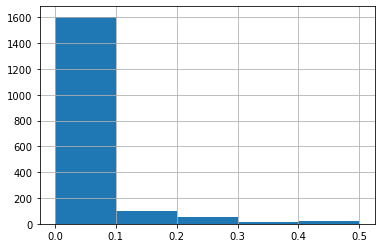

In [33]:
merged['ratio'].hist(bins=5)